In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from sklearn.metrics import mean_squared_error

# BKK

In [96]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[0]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [97]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,14.0,27.9,16.0,260.0
1,10.0,27.9,16.0,260.0
2,17.0,27.9,16.0,260.0
3,20.0,27.9,16.0,260.0
4,15.0,27.4,16.0,255.0


In [99]:
data_test = pd.read_csv(province+'_clean2.csv', date_parser = True)
data_test.sample(5)

,date_time,PM2.5,temp,wind speed,wind dir
1408,2021-06-18 00:00:00,14.0,29.0,19,255
373,2020-10-02 06:00:00,11.0,27.5,13,315
973,2021-03-01 06:00:00,28.0,26.3,26,160
915,2021-02-14 18:00:00,26.0,29.4,13,95
220,2020-08-25 00:00:00,10.0,29.5,19,295


In [21]:
# data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
# data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,9.0,29.4,35,270
1,2020-07-01 01:00:00,8.0,29.4,42,260
2,2020-07-01 02:00:00,12.0,28.5,42,260
3,2020-07-01 03:00:00,9.0,28.5,42,260
4,2020-07-01 04:00:00,8.0,28.3,55,270


In [104]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [105]:
scale

array([127. ,  20.9,  85. , 360. ])

In [101]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(26244, 60, 4)

In [24]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu' ,return_sequences = True))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 120, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [25]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 60)            15600     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_3 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_4 (LSTM)               (None, 120)               96480     
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 12)               

In [26]:
#create callback
filepath = province+'_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [27]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [28]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 154s 181ms/step - loss: 0.0067 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 159s 193ms/step - loss: 0.0044 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 166s 202ms/step - loss: 0.0036 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 161s 196ms/step - loss: 0.0032 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 177s 216ms/step - loss: 0.0031 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 186s 226ms/step - loss: 0.0030 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 190s 232ms/step - loss: 0.0030 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 211s 257ms/step - loss: 0.0030 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 195s 237ms/step - loss: 0.0029 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 177s 216ms/step - loss: 0.0028 - lr: 0.0010


In [102]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [30]:
past_60_days = data_training.tail(60)

In [63]:
past_60_days.head()

,PM2.5,temp,wind speed,wind dir
26244,14.0,31.6,12.0,260.0
26245,15.0,33.0,11.0,245.0
26246,18.0,33.0,11.0,245.0
26247,14.0,33.0,11.0,245.0
26248,13.0,32.5,15.0,250.0


In [103]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,14.0,31.6,12.0,260.0
1,15.0,33.0,11.0,245.0
2,18.0,33.0,11.0,245.0
3,14.0,33.0,11.0,245.0
4,13.0,32.5,15.0,250.0


In [23]:
# df.dropna(inplace=True)

df.shape

(7874, 4)

In [32]:
df.shape

(8844, 4)

In [33]:
inputs = scaler.transform(df)
inputs

array([[0.08661417, 0.68899522, 0.14117647, 0.72222222],
       [0.09448819, 0.75598086, 0.12941176, 0.68055556],
       [0.11811024, 0.75598086, 0.12941176, 0.68055556],
       ...,
       [0.08661417, 0.60287081, 0.23529412, 0.69444444],
       [0.08661417, 0.56937799, 0.18823529, 0.68055556],
       [0.08661417, 0.55980861, 0.16470588, 0.65277778]])

In [ ]:
inputs = scaler.transform(past_60_days)
X_test = []
ans_y_pred = []
scale = 1/scaler.scale_[0]
# print("inputs",inputs)

X_test.append(np.array(inputs))
X_test = np.array(X_test)

# print(X_test)

y_pred = modelLSTM.predict(X_test)

# print("y_pred",y_pred)

ans_y_pred.append(y_pred)


a = np.array(data_test)

for i in range(1, data_test.shape[0]):
    # print(y_pred[0][0])
    inputs = scaler.transform(np.array([[y_pred[0][0]*scale,a[i][1],a[i][2],a[i][3]]]))
    
    # print("inputs",inputs)

    X_test = np.append(X_test,np.array([inputs]),axis=1)
    # print("X_test -60",X_test[:,-60:,:].shape)
    # print(X_test)

    y_pred = modelLSTM.predict([X_test[:,-60:,:]])
    ans_y_pred.append(y_pred)


In [141]:
ans_y_pred = np.array(ans_y_pred)
ans_y_pred = ans_y_pred*scale
ans_y_pred

array([[[ 8.9753685 ,  9.220467  ,  9.379041  , ...,  9.868184  ,
         10.5587    , 10.694045  ]],

       [[ 8.843047  ,  9.207591  ,  9.408664  , ...,  9.632304  ,
         10.415709  , 10.448233  ]],

       [[ 8.676266  ,  9.21956   ,  9.46153   , ...,  9.360002  ,
         10.2280655 , 10.099113  ]],

       ...,

       [[-0.54244214, -0.6831215 , -0.7486347 , ...,  0.0271694 ,
         -1.4730366 , -1.4892795 ]],

       [[-0.5428689 , -0.6816794 , -0.749263  , ...,  0.02969392,
         -1.4704137 , -1.4873265 ]],

       [[-0.5421219 , -0.6807356 , -0.75142515, ...,  0.03100822,
         -1.4713031 , -1.4889985 ]]], dtype=float32)

In [142]:
ans_y_pred.shape

(1464, 1, 12)

In [155]:
df2 = []
for x in ans_y_pred:
    # print(x)
    a = []
    for i in range(0,12):
        a.append(x[0][i])
    df2.append(a)
df2 = pd.DataFrame(df2)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,8.975368,9.220467,9.379041,9.043898,9.047036,9.236771,9.879457,9.817023,9.265168,9.868184,10.558700,10.694045
1,8.843047,9.207591,9.408664,9.095198,9.037593,9.308188,9.906824,9.723071,8.908008,9.632304,10.415709,10.448233
2,8.676266,9.219560,9.461530,9.157233,9.074416,9.472742,9.979283,9.580980,8.485744,9.360002,10.228065,10.099113
3,8.494095,9.219607,9.491047,9.192157,9.138667,9.686892,10.074707,9.381606,8.079103,9.115675,10.019542,9.682838
4,8.460251,9.290161,9.573260,9.264891,9.210225,9.820296,10.069975,9.153856,7.752151,8.887491,9.787780,9.335746


In [156]:
df2.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
1459,-0.553225,-0.698471,-0.776282,-1.677598,-1.261987,-1.074880,-2.417591,-1.717431,-1.969948,0.011674,-1.502913,-1.518324
1460,-0.548444,-0.691769,-0.764864,-1.667830,-1.255974,-1.065362,-2.404826,-1.706669,-1.961450,0.018361,-1.490154,-1.505573
1461,-0.542442,-0.683122,-0.748635,-1.654985,-1.248819,-1.052791,-2.387982,-1.692942,-1.950768,0.027169,-1.473037,-1.489280
1462,-0.542869,-0.681679,-0.749263,-1.655486,-1.246852,-1.051193,-2.386865,-1.691979,-1.947216,0.029694,-1.470414,-1.487327
1463,-0.542122,-0.680736,-0.751425,-1.656706,-1.245119,-1.051192,-2.388205,-1.693242,-1.945785,0.031008,-1.471303,-1.488999


In [158]:
df2.to_csv(province+'_pred.csv',index=False)

In [69]:
X_test.shape

(60, 4)

In [34]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [61]:
inputs[0:5]

array([[0.08661417, 0.68899522, 0.14117647, 0.72222222],
       [0.09448819, 0.75598086, 0.12941176, 0.68055556],
       [0.11811024, 0.75598086, 0.12941176, 0.68055556],
       [0.08661417, 0.75598086, 0.12941176, 0.68055556],
       [0.07874016, 0.73205742, 0.17647059, 0.69444444]])

In [62]:
inputs[0:5,0]

array([0.08661417, 0.09448819, 0.11811024, 0.08661417, 0.07874016])

In [35]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((8784, 60, 4), (8784, 12))

In [58]:
(np.sum(np.isnan(X_test)))

58174

In [60]:
len(X_test)

8784

In [82]:
y_pred = modelLSTM.predict(X_test)

In [83]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [38]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

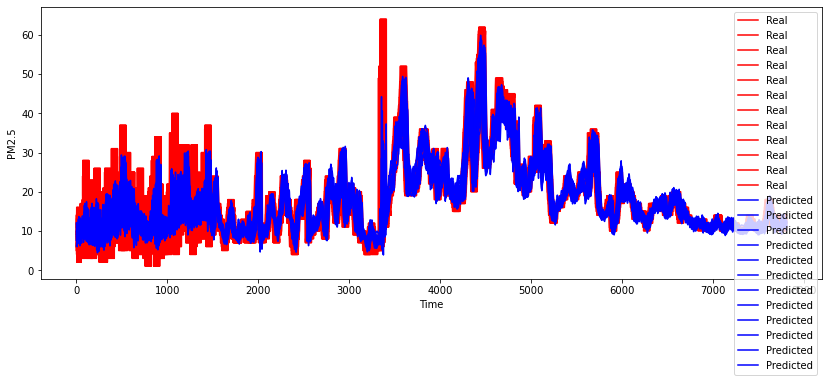

In [30]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [39]:
y_test.shape

(8784, 12)

In [40]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [84]:
y_pred

array([[12.54784  , 13.297471 , 13.065369 , 11.400027 , 11.389304 ,
        13.129357 , 11.112415 , 11.303342 ,  9.585312 , 14.548342 ,
        12.30231  , 12.3010845]], dtype=float32)

In [143]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

In [146]:
ans_y_pred.shape

(1464, 1, 12)

In [145]:
df1 = pd.DataFrame(ans_y_pred[0])
df1.to_csv('lstm_'+province.lower()+'.csv')

# Chiangmai

In [42]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[1]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [43]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,13.0,23.2,32.0,235.0
1,5.0,23.2,32.0,235.0
2,16.0,23.2,32.0,235.0
3,11.0,23.2,32.0,235.0
4,12.0,22.3,30.0,250.0


In [44]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
3033,3033,2020-11-04 09:00:00,19.0,21.3,21,175,18.840633,98.969661
6589,6589,2021-04-01 13:00:00,79.0,38.8,5,255,18.840633,98.969661
2662,2662,2020-10-19 22:00:00,11.0,20.0,13,100,18.840633,98.969661
8103,8103,2021-06-03 15:00:00,27.0,37.5,10,200,18.840633,98.969661
4820,4820,2021-01-17 20:00:00,44.0,19.7,24,155,18.840633,98.969661


In [45]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,13.0,25.2,17,225
1,2020-07-01 01:00:00,13.0,24.0,24,265
2,2020-07-01 02:00:00,11.0,24.0,24,265
3,2020-07-01 03:00:00,13.0,24.0,24,265
4,2020-07-01 04:00:00,12.0,23.4,23,280


In [46]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [47]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(26244, 60, 4)

In [48]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [41]:
modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 60)            15600     
                                                                 
 dropout_6 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 80)                45120     
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                972       
                                                                 
Total params: 61,692
Trainable params: 61,692
Non-trainable params: 0
_________________________________________________________________


In [49]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [50]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [51]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 96s 110ms/step - loss: 0.0016 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 85s 103ms/step - loss: 9.6090e-04 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 88s 107ms/step - loss: 8.2936e-04 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 88s 107ms/step - loss: 7.5509e-04 - lr: 0.0010
Epoch 5/10
168/821 [=====>........................] - ETA: 1:11 - loss: 6.7255e-04

KeyboardInterrupt: 

In [45]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [46]:
past_60_days = data_training.tail(60)

In [47]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,12.0,29.5,6.0,245.0
1,12.0,32.6,9.0,205.0
2,11.0,32.6,9.0,205.0
3,9.0,32.6,9.0,205.0
4,10.0,32.3,13.0,190.0


In [48]:
# df.dropna(inplace=True)
df.shape

(7937, 4)

In [49]:
df.shape

(7937, 4)

In [50]:
inputs = scaler.transform(df)
inputs

array([[0.02345416, 0.57412399, 0.09836066, 0.68055556],
       [0.02345416, 0.65768194, 0.14754098, 0.56944444],
       [0.02132196, 0.65768194, 0.14754098, 0.56944444],
       ...,
       [0.02558635, 0.42857143, 0.40983607, 0.69444444],
       [0.02558635, 0.41239892, 0.44262295, 0.72222222],
       [0.02558635, 0.40431267, 0.44262295, 0.72222222]])

In [51]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [52]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7877, 60, 4), (7877, 12))

In [53]:
y_pred = modelLSTM.predict(X_test)

In [54]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [55]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Chiangmai RMSE = 5.845155730544278


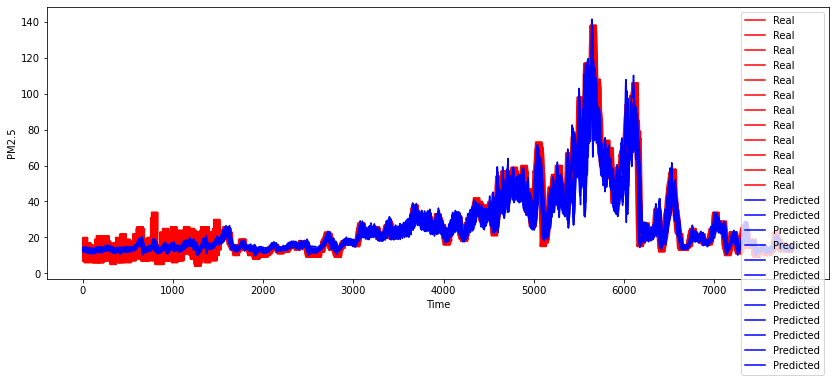

In [56]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [57]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [58]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Khonkaen

In [59]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[2]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [60]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,5.0,26.5,28.0,235.0
1,7.0,26.5,28.0,235.0
2,4.0,26.5,28.0,235.0
3,9.0,26.5,28.0,235.0
4,8.0,25.8,29.0,245.0


In [61]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
4839,4839,2021-01-18 15:00:00,39.0,26.1,20,60,16.445329,102.835251
8344,8344,2021-06-13 16:00:00,14.0,24.6,51,265,16.445329,102.835251
4652,4652,2021-01-10 20:00:00,27.0,19.8,7,60,16.445329,102.835251
4394,4394,2020-12-31 02:00:00,21.0,16.4,28,45,16.445329,102.835251
3753,3753,2020-12-04 09:00:00,25.0,17.5,25,45,16.445329,102.835251


In [62]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,11.0,27.6,21,230
1,2020-07-01 01:00:00,14.0,26.7,37,240
2,2020-07-01 02:00:00,15.0,26.7,37,240
3,2020-07-01 03:00:00,11.0,26.7,37,240
4,2020-07-01 04:00:00,9.0,25.5,39,255


In [63]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [64]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(26244, 60, 4)

In [65]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 100, activation = 'relu', input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [66]:
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               42000     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 43,212
Trainable params: 43,212
Non-trainable params: 0
_________________________________________________________________


In [67]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [68]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [69]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=8, callbacks=callbacks)

Epoch 1/10
3281/3281 [==============================] - 94s 28ms/step - loss: 0.0044 - lr: 0.0010
Epoch 2/10
3281/3281 [==============================] - 91s 28ms/step - loss: 0.0027 - lr: 0.0010
Epoch 3/10
3281/3281 [==============================] - 115s 35ms/step - loss: 0.0024 - lr: 0.0010
Epoch 4/10
3281/3281 [==============================] - 124s 38ms/step - loss: 0.0022 - lr: 0.0010
Epoch 5/10
3281/3281 [==============================] - 122s 37ms/step - loss: 0.0021 - lr: 0.0010
Epoch 6/10
3281/3281 [==============================] - 122s 37ms/step - loss: 0.0020 - lr: 0.0010
Epoch 7/10
3281/3281 [==============================] - 126s 38ms/step - loss: 0.0020 - lr: 0.0010
Epoch 8/10
3281/3281 [==============================] - 134s 41ms/step - loss: 0.0019 - lr: 0.0010
Epoch 9/10
3281/3281 [==============================] - 125s 38ms/step - loss: 0.0018 - lr: 0.0010
Epoch 10/10
3281/3281 [==============================] - 124s 38ms/step - loss: 0.0018 - lr: 0.0010


In [70]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [72]:
past_60_days = data_training.tail(60)

In [73]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,13.0,29.6,15.0,195.0
1,20.0,29.6,7.0,200.0
2,16.0,29.6,7.0,200.0
3,9.0,29.6,7.0,200.0
4,16.0,29.6,7.0,200.0


In [74]:
df.dropna(inplace=True)
df.shape

(7909, 4)

In [75]:
df.shape

(7909, 4)

In [76]:
inputs = scaler.transform(df)
inputs

array([[0.06976744, 0.60759494, 0.17647059, 0.54166667],
       [0.11046512, 0.60759494, 0.08235294, 0.55555556],
       [0.0872093 , 0.60759494, 0.08235294, 0.55555556],
       ...,
       [0.0872093 , 0.7056962 , 0.36470588, 0.625     ],
       [0.0872093 , 0.7056962 , 0.32941176, 0.61111111],
       [0.0872093 , 0.53797468, 0.34117647, 0.63888889]])

In [77]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [78]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7849, 60, 4), (7849, 12))

In [79]:
y_pred = modelLSTM.predict(X_test)

In [80]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [81]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

Khonkaen RMSE = 4.105126158005483


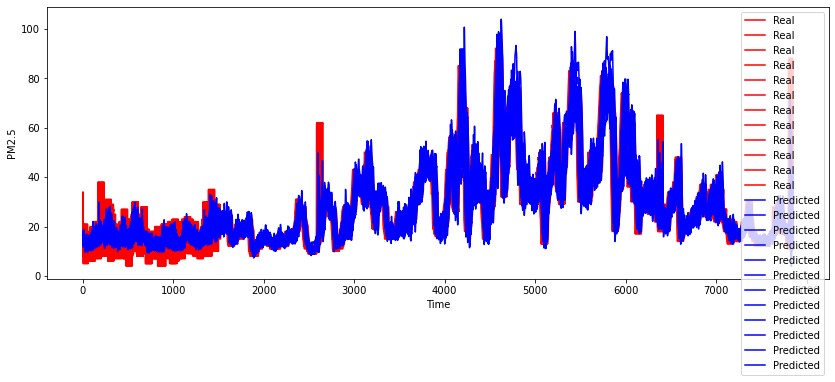

In [82]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Rayong

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[3]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 120, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test.head()

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Saraburi

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[4]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Surat

In [7]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[5]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [8]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,22.0,25.8,3.0,90.0
1,17.0,25.8,3.0,90.0
2,13.0,25.8,3.0,90.0
3,12.0,25.8,3.0,90.0
4,11.0,25.2,1.0,105.0


In [9]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
1500,1500,2020-09-01 12:00:00,11.0,30.3,30,195,14.685833,100.871996
1711,1711,2020-09-10 07:00:00,9.0,25.4,4,195,14.685833,100.871996
3835,3835,2020-12-07 19:00:00,15.0,23.7,12,75,14.685833,100.871996
5086,5086,2021-01-28 22:00:00,NaN,23.5,34,80,14.685833,100.871996
4904,4904,2021-01-21 08:00:00,35.0,22.6,4,135,14.685833,100.871996


In [10]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,19.0,25.9,23,260
1,2020-07-01 01:00:00,22.0,25.2,21,255
2,2020-07-01 02:00:00,28.0,25.2,21,255
3,2020-07-01 03:00:00,25.0,25.2,21,255
4,2020-07-01 04:00:00,19.0,24.7,29,255


In [11]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [12]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(15276, 60, 4)

In [13]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 240, activation = 'relu'))
modelLSTM.add(Dropout(0.2))



modelLSTM.add(Dense(units = 12))

In [14]:
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 120)           60000     
                                                                 
 dropout (Dropout)           (None, 60, 120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 240)               346560    
                                                                 
 dropout_1 (Dropout)         (None, 240)               0         
                                                                 
 dense (Dense)               (None, 12)                2892      
                                                                 
Total params: 409,452
Trainable params: 409,452
Non-trainable params: 0
_________________________________________________________________


In [15]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [16]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [17]:
history = modelLSTM.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=callbacks)

Epoch 1/15
 20/239 [=>............................] - ETA: 1:23 - loss: 0.0269

KeyboardInterrupt: 

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
past_60_days = data_training.tail(90)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Submit

In [ ]:
param_dict = {'BKK':[7.0, 70.0, 40.0, 100.0],
'Chiangmai':[7.0, 50.0, 40.0, 100.0],
'Rayong':[2.0, 50.0, 30.0, 40.0],
'Saraburi':[3.0, 50.0, 20.0, 90.0],
'Khonkaen':[1.0, 70.0, 30.0, 90.0],
'Surat':[2.0, 60.0, 20.0, 30.0]}

In [ ]:
ans = pd.DataFrame.from_dict({'Time':[],'Predicted':[],'PM2.5':[],'Province':[]})
for key,value in param_dict.items():
    
    df1 = pd.read_csv(key+'_clean.csv')
    df1.dropna(inplace=True)
    df1.reset_index(inplace=True)
    
    df2 = pd.read_csv('lstm_'+key.lower()+'.csv')
   

    df3 =  pd.DataFrame()
    df3['Predicted']=df1['date_time'].copy()
    df3['PM2.5']=df2['0'].copy()


    df3['Predicted'] = pd.to_datetime(df3['Predicted'])

    submit=pd.read_csv('submit_time_format_2.csv')
    submit['Predicted'] = pd.to_datetime(submit['Predicted'])
    submit['Time'] = pd.to_datetime(submit['Time'])

   
    result = pd.merge(submit, df3, how="left", on=["Predicted"])

    result['Province'] = key

    
    ans = pd.concat([ans,result])

In [ ]:
ans.dropna(inplace=True)
ans.reset_index(inplace=True)
ans['PM2.5'].to_csv('kaggle_lstm.csv')